# TP SVM Linéaire 

**Chargement des modules nécessaires**

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.svm import SVC
%matplotlib inline
plt.close("all")


**Définition de fonctions**

In [0]:
def mesh(X, h = 0.02):
    """
    crée des données sur sur grille 2D avec un pas h
    """
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return np.c_[xx.ravel(), yy.ravel()], xx, yy


In [0]:
# creation des données suivant une loi Gaussienne

n_train = 300  # nombre d'exemple dans une classe
sigma = 0.3    # variance des Gaussiennes
m = np.array([-1,-1])
X1 = sigma * np.random.randn(n_train,2) + m

m = np.array([1,1])
X2 = sigma*np.random.randn(n_train,2) + m

X = np.concatenate((X1,X2),axis=0)
y = np.concatenate((-1*np.ones((n_train)),np.ones((n_train))), axis = 0  )

# données de test sur la grille
xtest_grid, x_grid, y_grid  = mesh(X)

In [72]:
# Definition et apprentissage d'un SVM à partir des données X et y
C = 100000
clf = SVC(C=C,kernel='linear')
clf.fit(X, y)


SVC(C=100000, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

On cherche maintenant à vérifier les propriétés des SVMs à partir de la solution du problème d'optimisation. On en extrait les
1. indices des points supports
2. le vecteurs $\alpha$ solution du problème dual 
3. $b$ la valeur du biais

In [0]:
#%% Extraction de paramètres du modèle
indice_SV = clf.support_
alpha_y = clf.dual_coef_[0]
b = clf.intercept_

**Question** 

calculer le vecteur w du modèle linéaire

In [0]:
d = 2
w = np.zeros(d)
# insérer votre code ici
for i in range(len(indice_SV)):
  w += alpha_y[i] * X[indice_SV[i]]

,**Exploitation du vecteur w**

1. Verifier que les points supports sont telles que $f(x) = w^\top x + b = \pm 1$ 
2. En appliquant la frontière de décision sur les données de grille 2D, tracer la frontière
de décision f(x) = 0, ainsi que les frontières de marge f(x)= {-1,1} et les points supports.
3. Que devient cette figure lorsque la variance des classes Gaussiennes devient plus grande?

In [75]:
# insérer votre code pour la question 1 ici
print(X[indice_SV].dot(w) +b)


[-1.00000002  1.00000002]


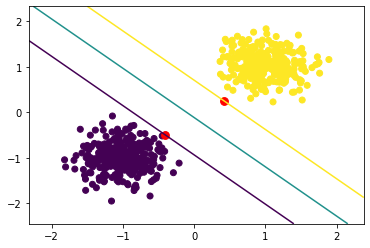

In [76]:
# insérer votre code pour la question 2 ici
Z = xtest_grid.dot(w) +b
Z = Z.reshape(x_grid.shape)
plt.figure(1)
plt.contour(x_grid, y_grid, Z, levels=[-1,0,1])
plt.scatter(X[:,0],X[:,1], c=y)
plt.scatter(X[indice_SV,0],X[indice_SV,1],marker='o',c='r',s=60)
plt.show()

In [0]:
from scipy.io import loadmat
def extraire_classe(X_a,y_a, classe_pos,classe_neg):
    # Fonction permettant d'extraire la classe positive et négative de l'ensemble
    # des données
    indpos = [ ind for ind,y in enumerate(y_a) if y == classe_pos]
    indneg = [ ind for ind,y in enumerate(y_a) if y == classe_neg]
    ind = np.concatenate((indpos,indneg))
    y = np.zeros(len(ind))
    y[0:len(indpos)] = 1
    y[len(indpos):len(indpos)+len(indneg)] = -1
    return X_a[ind],y

**Probleme réel**

Application à la classification de caractéres manuscrits. On cherche à mettre en oeuvre
un classifieur SVM qui discrimine deux classes de la base MNIST.

In [84]:
from google.colab import files
uploaded = files.upload()

Saving mnist.mat to mnist.mat


In [0]:
# lecture et création des données
data = loadmat('mnist.mat')
X_af = data['xapp']
y_af = data['yapp'].squeeze()
X_tf = data['xtest']
y_tf = data['ytest'].squeeze()

In [0]:
classe_pos = 1
classe_neg = 8
X_app, y_app= extraire_classe(X_af,y_af,classe_pos,classe_neg)
X_test, y_test= extraire_classe(X_tf,y_tf,classe_pos,classe_neg)

** Question **
Afficher quelques images de la base d'apprentissage

KeyboardInterrupt: ignored

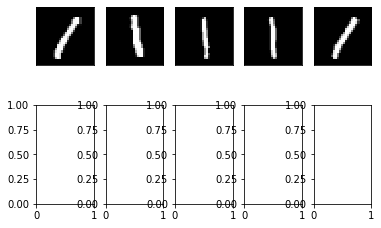

In [95]:
# inserer ici votre code permettant d'afficher 5 images de la classe 1 et
# 5 de la classe 8
k = 0
fig, axs = plt.subplots(nrows=2, ncols=5)
for i in range(5):
  idx = np.random.randint(len(X_app))
  while(y_app[idx] != classe_pos):
    idx = np.random.randint(len(X_app))
  axs[0,i].imshow(X_app[i].reshape(28,28),cmap = 'gray')
  axs[0,i].get_xaxis().set_visible(False) 
  axs[0,i].get_yaxis().set_visible(False)   

for i in range(5):
  idx = np.random.randint(len(X_app))
  while(y_app[idx] != classe_neg):
    idx = np.random.randint(len(X_app))
  axs[0,i].imshow(X_app[i].reshape(28,28),cmap = 'gray')
  axs[0,i].get_xaxis().set_visible(False) 
  axs[0,i].get_yaxis().set_visible(False)   

Mettre en oeuvre un classifieur linéaire SVM avec une approche de type validation croisée
pour sélectionner le paramètre $C$ du modèle. On réalisera l'apprentissage et la sélection du modèle sur les données
d'apprentissage et on les évaluera sur le test.

In [0]:
from sklearn.model_selection import StratifiedKFold

nb_iter = 4
C_vec = np.logspace(-4,3,2) # all the C's to evaluate from 10e-4 to 10e3 (we take 2)
perf_val = np.zeros((len(C_vec), nb_iter))

# Insérer votre code ici
kf = StratifiedKFold(n_splits = nb_iter)
for i, (ind_a, ind_v) in enumerate(kf.split(X_app,y_app)):
  X_a,X_v = X_app[ind_a], X_app[ind_v]
  y_a,y_v = y_app[ind_a], y_app[ind_v]

  for i_C, C in enumerate(C_vec):
    clf = SVC(C=C,kernel = 'linear')
    clf.fit(X_a,y_a)
    res = clf.predict(X_v)
    perf_val[i_C,i] = np.mean(res == y_v)

In [111]:
print(perf_val.shape)
m_perf = perf_val.mean(axis =1) # we mean all the cross_val results for each C, m_perf is of shape (6,1)
print(m_perf.shape)
print(m_perf)
ind_max = np.unravel_index(np.argmax(m_perf), m_perf.shape) # argmax on m_perf returns the index of the best row
print(ind_max)
C_opt = C_vec[ind_max[0]] # if there are multiple indices that gives the max, we take one arbitrarely
clf = SVC(C=C_opt,kernel='linear')
[clf.fit(X_app, y_app)
y_pred = clf.predict(X_test)
print('Accuracy = ', np.mean(y_pred == y_test))

(2, 4)
(2,)
[0.9786394  0.97347739]
(0,)
Erreur de test =  0.9881460407776197


On cherche maintenant à analyser les résultats obtenus

1. Afficher 25 exemples de points mal classés
2. Calculer et afficher la matrice de confusion 

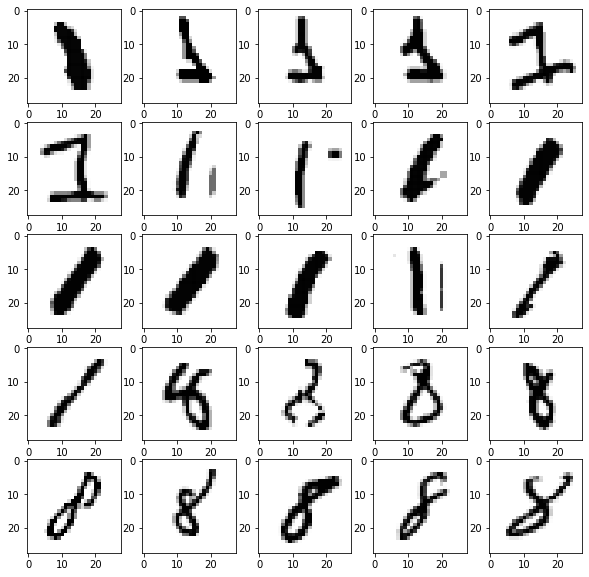

In [124]:
# Insérer votre code ici
indices_bad_class = np.where((y_pred == y_test) != 1)[0]
X_wrongly_labeled = X_test[y_pred != y_test]

fig, axs = plt.subplots(5, 5, figsize=(10, 10))
for index in range(25):
  axs[index // 5, index % 5].imshow(X_wrongly_labeled[index].reshape(28,28),cmap='Greys')

In [0]:
Confusion = np.zeros((2,2))

# insérer votre code ici
            
print(Confusion)